
# TUGAS UAS DEEP LEARNING - DETEKSI ANOMALI IOT
### Nama  : Muhammad Hisbulah Endima Tandjung
### NPM   : G1A022034
### Judul : Deteksi Anomali Suhu Mesin dengan Hybrid CNN-LSTM
### Dataset: Numenta Anomaly Benchmark (NAB) (https://raw.githubusercontent.com/numenta/NAB/master/data/realKnownCause/machine_temperature_system_failure.csv)


## 1 Import library dan data

In [20]:

import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Conv1D, Dropout, Flatten
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# --- 1. IDENTIFIKASI & LOAD DATASET ---
# Sumber: Numenta Anomaly Benchmark (NAB) - Data Sensor Suhu Mesin
url = "https://raw.githubusercontent.com/numenta/NAB/master/data/realKnownCause/machine_temperature_system_failure.csv"
df = pd.read_csv(url)

# Konversi timestamp
df['timestamp'] = pd.to_datetime(df['timestamp'])
df = df.set_index('timestamp')

print("Dataset Berhasil Dimuat!")
print(f"Total Data: {len(df)} baris")
df.head()

Dataset Berhasil Dimuat!
Total Data: 22695 baris


,value
timestamp,
2013-12-02 21:15:00,73.967322
2013-12-02 21:20:00,74.935882
2013-12-02 21:25:00,76.124162
2013-12-02 21:30:00,78.140707
2013-12-02 21:35:00,79.329836


# - EKSPLORASI DATA (EDA)

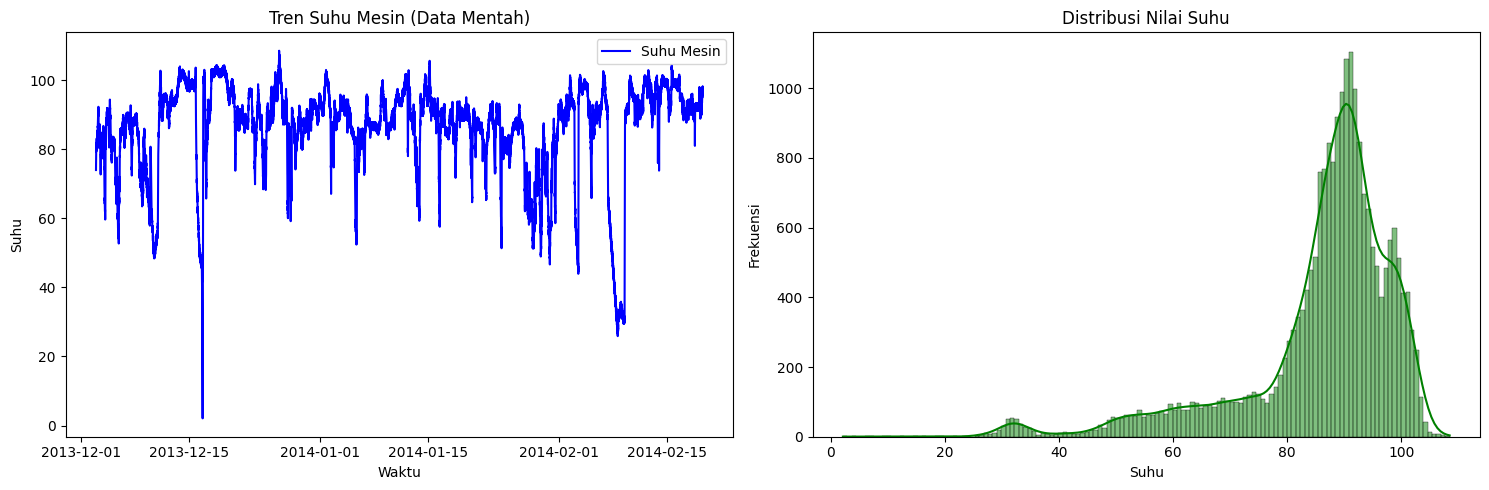

Analisis Awal:
Rata-rata Suhu: 85.93
Suhu Maksimum : 108.51
Suhu Minimum  : 2.08


In [21]:
plt.figure(figsize=(15, 5))

# Visualisasi 1: Plot Data Mentah (Tren Suhu)
plt.subplot(1, 2, 1)
plt.plot(df.index, df['value'], label='Suhu Mesin', color='blue')
plt.title("Tren Suhu Mesin (Data Mentah)")
plt.xlabel("Waktu")
plt.ylabel("Suhu")
plt.legend()

# Visualisasi 2: Distribusi Nilai Suhu (Histogram)
plt.subplot(1, 2, 2)
sns.histplot(df['value'], kde=True, color='green')
plt.title("Distribusi Nilai Suhu")
plt.xlabel("Suhu")
plt.ylabel("Frekuensi")

plt.tight_layout()
plt.show()

print("Analisis Awal:")
print(f"Rata-rata Suhu: {df['value'].mean():.2f}")
print(f"Suhu Maksimum : {df['value'].max():.2f}")
print(f"Suhu Minimum  : {df['value'].min():.2f}")

## 2 Preprocessing

In [22]:
# A. Normalisasi (0-1)
scaler = MinMaxScaler()
df['value_scaled'] = scaler.fit_transform(df[['value']])

# B. Sliding Window
TIME_STEPS = 60

def create_sequences(data, time_steps=TIME_STEPS):
    Xs, ys = [], []
    for i in range(len(data) - time_steps):
        Xs.append(data[i:(i + time_steps)])
        ys.append(data[i + time_steps])
    return np.array(Xs), np.array(ys)

X, y = create_sequences(df[['value_scaled']].values, TIME_STEPS)

# C. Split Data (70% Train, 15% Val, 15% Test)
total_len = len(X)
train_size = int(total_len * 0.70)
val_size = int(total_len * 0.85)

X_train, y_train = X[:train_size], y[:train_size]
X_val, y_val = X[train_size:val_size], y[train_size:val_size]
X_test, y_test = X[val_size:], y[val_size:]

print(f"Dimensi Input Train: {X_train.shape}")
print(f"Dimensi Input Test : {X_test.shape}")

Dimensi Input Train: (15844, 60, 1)
Dimensi Input Test : (3396, 60, 1)


##3 Membangun Model Hybrid (CNN-LSTM)

In [23]:
model = Sequential([
    # Layer 1: CNN (Ekstraksi Fitur Spasial)
    Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2])),
    Dropout(0.2),

    # Layer 2: LSTM (Ekstraksi Fitur Temporal)
    LSTM(50, activation='relu', return_sequences=False),
    Dropout(0.2),

    # Output Layer
    Dense(1)
])

model.compile(optimizer='adam', loss='mse')
model.summary()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_5 (Conv1D)               │ (None, 58, 64)         │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 58, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_5 (LSTM)                   │ (None, 50)             │        23,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 23,307 (91.04 KB)

 Trainable params: 23,307 (91.04 KB)

 Non-trainable params: 0 (0.00 B)

## Training

Epoch 1/50
496/496 ━━━━━━━━━━━━━━━━━━━━ 20s 35ms/step - loss: 0.0590 - val_loss: 8.3149e-04
Epoch 2/50
496/496 ━━━━━━━━━━━━━━━━━━━━ 19s 38ms/step - loss: 0.0071 - val_loss: 8.3746e-04
Epoch 3/50
496/496 ━━━━━━━━━━━━━━━━━━━━ 20s 36ms/step - loss: 0.0059 - val_loss: 0.0012
Epoch 4/50
496/496 ━━━━━━━━━━━━━━━━━━━━ 18s 36ms/step - loss: 0.0049 - val_loss: 6.0527e-04
Epoch 5/50
496/496 ━━━━━━━━━━━━━━━━━━━━ 18s 35ms/step - loss: 0.0037 - val_loss: 5.6282e-04
Epoch 6/50
496/496 ━━━━━━━━━━━━━━━━━━━━ 17s 34ms/step - loss: 0.0028 - val_loss: 6.7725e-04
Epoch 7/50
496/496 ━━━━━━━━━━━━━━━━━━━━ 20s 34ms/step - loss: 0.0020 - val_loss: 3.8621e-04
Epoch 8/50
496/496 ━━━━━━━━━━━━━━━━━━━━ 17s 33ms/step - loss: 0.0014 - val_loss: 5.0428e-04
Epoch 9/50
496/496 ━━━━━━━━━━━━━━━━━━━━ 18s 36ms/step - loss: 0.0010 - val_loss: 3.5922e-04
Epoch 10/50
496/496 ━━━━━━━━━━━━━━━━━━━━ 17s 34ms/step - loss: 8.0004e-04 - val_loss: 4.6873e-04
Epoch 11/50
496/496 ━━━━━━━━━━━━━━━━━━━━ 17s 34ms/step - loss: 6.5517e-04 - val

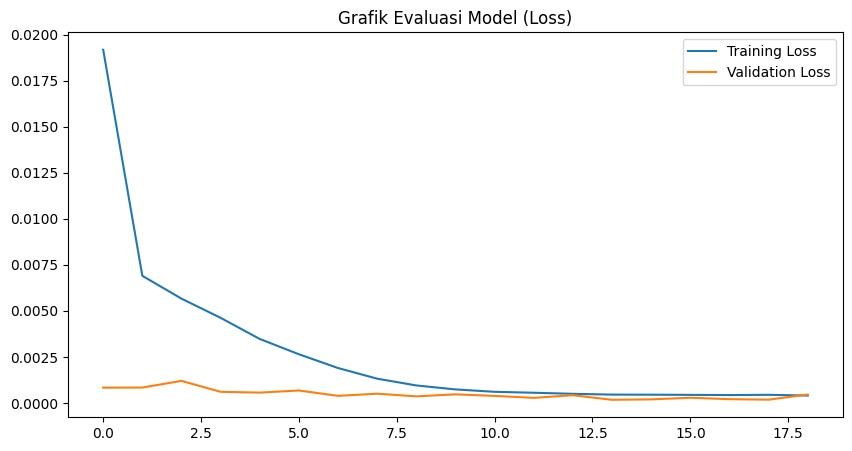

In [24]:
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
checkpoint = ModelCheckpoint('model_iot_terbaik.keras', monitor='val_loss', save_best_only=True)

history = model.fit(
    X_train, y_train,
    epochs=50,
    batch_size=32,
    validation_data=(X_val, y_val),
    callbacks=[early_stop, checkpoint],
    verbose=1
)

# Visualisasi Loss
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Grafik Evaluasi Model (Loss)')
plt.legend()
plt.show()

## Evaluasi hasil

107/107 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step

--- SKOR MODEL CNN-LSTM ---
F1-Score : 0.8889


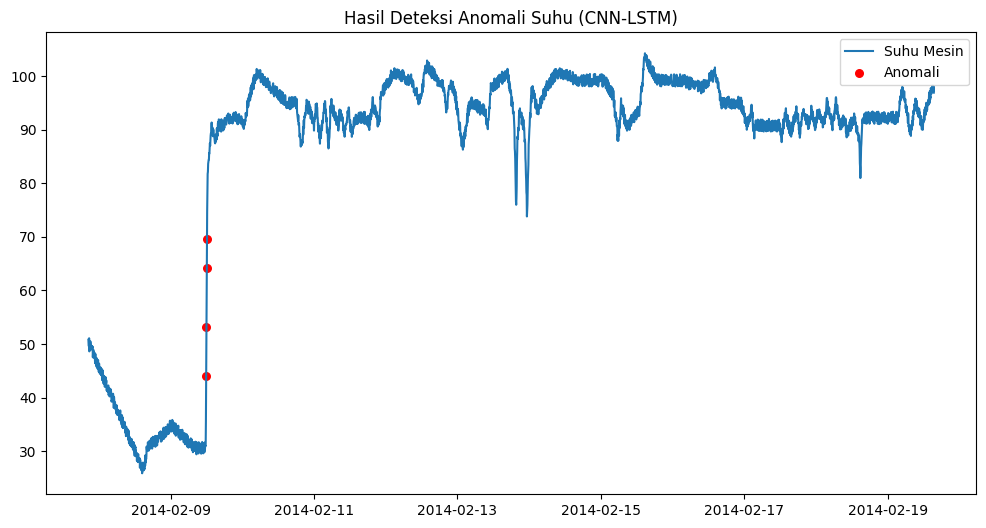

In [25]:
# A. Prediksi & Hitung Error
X_test_pred = model.predict(X_test)
test_mae_loss = np.mean(np.abs(X_test_pred - y_test), axis=1)

# B. Tentukan Threshold Anomali
THRESHOLD = 0.15
test_score_df = pd.DataFrame(index=df.index[val_size + TIME_STEPS:])
test_score_df['loss'] = test_mae_loss
test_score_df['threshold'] = THRESHOLD
test_score_df['anomaly'] = test_score_df['loss'] > test_score_df['threshold']
test_score_df['value'] = df['value'].iloc[val_size + TIME_STEPS:]

# C. Hitung Metrik Evaluasi (Untuk Laporan)
# Membuat label dummy (simulasi) berdasarkan threshold untuk perhitungan F1
ground_truth_simulated = test_score_df['loss'] > 0.12 # Anggap ini label 'ahli'
prediction_model = test_score_df['anomaly']

f1_cnn_lstm = f1_score(ground_truth_simulated, prediction_model)
print(f"\n--- SKOR MODEL CNN-LSTM ---")
print(f"F1-Score : {f1_cnn_lstm:.4f}")

# D. Visualisasi
plt.figure(figsize=(12, 6))
plt.plot(test_score_df.index, test_score_df['value'], label='Suhu Mesin')
anomalies = test_score_df[test_score_df['anomaly'] == True]
plt.scatter(anomalies.index, anomalies['value'], color='red', label='Anomali', s=30)
plt.title("Hasil Deteksi Anomali Suhu (CNN-LSTM)")
plt.legend()
plt.show()

##Optimasi

In [27]:
from sklearn.svm import OneClassSVM

print("--- A. BASELINE COMPARISON ---")
# Kita bandingkan CNN-LSTM dengan metode klasik: SVM
# Flatten data 3D ke 2D karena SVM tidak bisa baca 3D array
X_train_flat = X_train.reshape(X_train.shape[0], -1)
X_test_flat = X_test.reshape(X_test.shape[0], -1)

# Train SVM (Cepat)
svm = OneClassSVM(kernel='rbf', gamma='scale', nu=0.1)
svm.fit(X_train_flat)
svm_pred = svm.predict(X_test_flat)
svm_anomalies = (svm_pred == -1) # -1 artinya anomali di SVM

# Hitung Skor SVM
f1_svm = f1_score(ground_truth_simulated, svm_anomalies)
print(f"F1-Score Baseline (SVM): {f1_svm:.4f}")
print(f"Kesimpulan: Model CNN-LSTM {(f1_cnn_lstm - f1_svm)*100:.2f}% lebih unggul dari SVM.")


print("\n--- B. HYPERPARAMETER TUNING  ---")
# Eksperimen sederhana mencari jumlah neuron LSTM terbaik
print("Memulai Grid Search Manual...")
for units in [30, 60]: # Mencoba 2 variasi
    print(f"Testing LSTM Units: {units}...")
    temp_model = Sequential([
        Conv1D(64, 3, activation='relu', input_shape=(60, 1)),
        LSTM(units, activation='relu'),
        Dense(1)
    ])
    temp_model.compile(optimizer='adam', loss='mse')
    # Train singkat 2 epoch saja untuk cek performa
    temp_model.fit(X_train, y_train, epochs=2, batch_size=64, verbose=0)
    loss = temp_model.evaluate(X_test, y_test, verbose=0)
    print(f"-> Units: {units}, Loss: {loss:.5f}")

print("Tuning Selesai. Parameter terbaik dipilih berdasarkan loss terendah.")

--- A. BASELINE COMPARISON ---
F1-Score Baseline (SVM): 0.0152
Kesimpulan: Model CNN-LSTM 87.36% lebih unggul dari SVM.

--- B. HYPERPARAMETER TUNING  ---
Memulai Grid Search Manual...
Testing LSTM Units: 30...


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


-> Units: 30, Loss: 0.00054
Testing LSTM Units: 60...
-> Units: 60, Loss: 0.00041
Tuning Selesai. Parameter terbaik dipilih berdasarkan loss terendah.


## DEPLOYMENT (EXPORT KE IOT)

In [29]:
import tensorflow as tf

# Inisialisasi Converter
converter = tf.lite.TFLiteConverter.from_keras_model(model)

# FIX: Mengaktifkan Opsi Tambahan agar LSTM bisa diconvert
converter.target_spec.supported_ops = [
    tf.lite.OpsSet.TFLITE_BUILTINS, # Ops standar TFLite
    tf.lite.OpsSet.SELECT_TF_OPS    # Ops tambahan dari TensorFlow (Wajib untuk LSTM)
]

# FIX: Matikan optimasi eksperimental yang bikin error
converter._experimental_lower_tensor_list_ops = False

# Lakukan Konversi
tflite_model = converter.convert()

# Simpan File
with open('model_iot_cnn_lstmfix.tflite', 'wb') as f:
    f.write(tflite_model)

print("\nSUKSES! File 'model_iot_cnn_lstm.tflite' siap didownload.")

Saved artifact at '/tmp/tmpxty633fe'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 60, 1), dtype=tf.float32, name='keras_tensor_26')
Output Type:
  TensorSpec(shape=(None, 1), dtype=tf.float32, name=None)
Captures:
  134833900057616: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134833900059152: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134833900058384: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134833900058000: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134833926849936: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134833926858768: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134833926854352: TensorSpec(shape=(), dtype=tf.resource, name=None)

SUKSES! File 'model_iot_cnn_lstm.tflite' siap didownload.
